# Predicting Resolver Response Code Based on Query

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.preprocessing, sklearn.model_selection, sklearn.tree
import graphviz 
import matplotlib.pyplot as plt

In [2]:
ALGO_NAME = {
    5: 'rsasha1', 
    7: 'rsasha1nsec3sha1', 
    8: 'rsasha256', 
    10: 'rsasha512',
    13: 'ecdsap256sha256', 
    14: 'ecdsap384sha384', 
    15: 'ed25519', 
    16: 'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}
# defining priority (from low to high)
priority = [ALGO_NAME[key] for key in sorted(ALGO_NAME.keys())]

## Prepare Data

In [3]:
data = {
    name: pd.read_pickle(f'ml_data_{name}.pickle')
    for name in ALGO_NAME.values()
}

In [4]:
features = list(filter(lambda c: c.startswith('feature_dns'), next(iter(data.values())).keys()))
labels = list(filter(lambda c: c.startswith('label_'), next(iter(data.values())).keys()))
label = 'label_rcode0andad1'

### Display all Features that have *any* Variability

In [5]:
features = list(filter(lambda f: f != 'feature_ip_src', features))

In [6]:
for algo, d in data.items():
    print(f'++++{algo}++++', len(d), 'total queries')
    for c in features + labels:
        u = np.unique(d[c], return_counts=True)
        if len(u[0]) > 1:
            print(f"{c}: {len(u[0])} unique values")

++++rsasha1++++ 32 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 3 unique values
feature_dns_edns_cookie: 2 unique values
label_resolver: 8 unique values
++++rsasha1nsec3sha1++++ 26 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 3 unique values
feature_dns_edns_cookie: 2 unique values
label_resolver: 8 unique values
++++rsasha256++++ 32 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 3 unique values
feature_dns_edns_cookie: 2 unique values
label_resolver: 8 unique values
++++rsasha512++++ 32 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 3 unique values
feature_dns_edns_cookie: 2 unique values
label_resolver: 8 unique values
++++ecdsap256sha256++++ 8 total queries
feature_dns_cd: 2 unique values
feature_dns_edns_requestors_udp_payload_size: 3 unique values
feature_dns_edns_cookie: 2 unique values
label_resolv

In [7]:
data['ed448'].keys()

Index(['index', 'id', 'qname', 'tag', 'started', 'client_packets',
       'client_query', 'client_response', 'server_packets', 'finished',
       'zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status',
       'low_label', 'high_label', 'num_client_packets',
       'client_response_rcode', 'client_response_ad', 'num_server_packets',
       'server_query', 'validated_response', 'rc0&ad1', 'rc0', 'resolver',
       'label_rcode', 'label_resolver', 'label_rcode0andad1', 'feature_ip_ttl',
       'feature_ip_src', 'feature_ip_proto', 'feature_ip_df', 'feature_ip_ihl',
       'feature_ip_id_is_zero', 'feature_dns_qr', 'feature_dns_opcode',
       'feature_dns_aa', 'feature_dns_tc', 'feature_dns_rd', 'feature_dns_ra',
       'feature_dns_z', 'feature_dns_cd', 'feature_dns_rcode',
       'feature_dns_qdcount', 'feature_dns_ancount', 'feature_dns_nscount',
       'feature_dns_arcount', 'feature_dns_edns_requestors_udp_payload_size',
       'feature_dns_0x20', 'feature_dns_edns_cookie',
   

In [8]:
tdata = data['ed448'][['feature_dns_cd', 'feature_dns_edns_requestors_udp_payload_size', 'feature_dns_0x20', 'feature_dns_edns_cookie', 'feature_dns_edns_subnet', 'client_response_rcode', 'client_response_ad', 'label_rcode0andad1']]
tdata.columns = ['CD bit set', 'Advertised UDP Payload Size', 'Uses 0x20 Encoding', 'Sets EDNS Cookie', 'Advertises Subnet', 'Response Code', 'AD bit set', 'Label']
print(tdata[:25].to_latex(
    index=False,
))
tdata

\begin{tabular}{rrlllrrl}
\toprule
 CD bit set &  Advertised UDP Payload Size &  Uses 0x20 Encoding &  Sets EDNS Cookie &  Advertises Subnet &  Response Code &  AD bit set &  Label \\
\midrule
          1 &                         4000 &                True &             False &              False &              0 &           0 &  False \\
          1 &                         4000 &                True &             False &              False &              0 &           0 &  False \\
          1 &                         4000 &                True &             False &              False &              0 &           0 &  False \\
          1 &                         4000 &                True &             False &              False &              0 &           0 &  False \\
          0 &                         4096 &                True &              True &              False &              0 &           0 &  False \\
          1 &                         1232 &                Tr

,CD bit set,Advertised UDP Payload Size,Uses 0x20 Encoding,Sets EDNS Cookie,Advertises Subnet,Response Code,AD bit set,Label
11,1,4000,True,False,False,0,0,False
58,1,4000,True,False,False,0,0,False
103,1,4000,True,False,False,0,0,False
148,1,4000,True,False,False,0,0,False
193,0,4096,True,True,False,0,0,False
238,1,1232,True,False,False,0,0,False
283,0,1232,True,False,False,0,1,True
328,1,4096,True,False,False,0,0,False


### Encode String-Based Features

In [9]:
for d in data.values():
    le_feature_ip_src = sk.preprocessing.LabelEncoder()
    le_feature_ip_src.fit(d['feature_ip_src'])
    d['feature_ip_src'] = le_feature_ip_src.transform(d['feature_ip_src'])

## Train and Evaluate Decision Tree

In [10]:
tree = {}

for algo, d in data.items():
    d['status'] = 'unassigned'
    X = d[features + ['status']]
    Y = d[label]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.7, random_state=1)
    d.loc[X_train.index, 'status'] = 'training'
    d.loc[X_test.index, 'status'] = 'test'
    X = d[features + ['status']]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.7, random_state=1)
    assert set(X_train['status']) == {'training'}
    assert set(X_test['status']) == {'test'}, set(X_test['status'])
    X = d[features]
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.7, random_state=1)

    tree[algo] = sk.tree.DecisionTreeClassifier()
    tree[algo] = tree[algo].fit(X_train, Y_train)

### Evaluate Prediction Error

In [14]:
metrics = []

for seed in range(10):
    for algo, t in tree.items():
        d = data[algo]
        X_test = d[d['status'] == 'test'][features]
        Y_test = d[d['status'] == 'test'][label]
        cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test) / len(Y_test)
        try:
            metrics.append({
                'algo': algo,
                'true negative': cm[0,0],
                'true positive': cm[1,1],
                'false negative': cm[0,1],
                'false positive': cm[1,0],
                'seed': seed,
            })
        except IndexError:
            metrics.append({
                'algo': algo,
                'true negative': 1,
                'true positive': 1,
                'false negative': 0,
                'false positive': 0,
                'seed': seed,                
            })
        
metrics = pd.DataFrame(metrics)
metrics = metrics.groupby(['algo']).mean().sort_values('algo', key=lambda r: list(map(lambda e: priority.index(e), r)))
del metrics['seed']
print(metrics.to_latex(
    float_format=lambda f: f"{f:.0%}",
))
metrics

\begin{tabular}{lrrrr}
\toprule
{} &  true negative &  true positive &  false negative &  false positive \\
algo             &                &                &                 &                 \\
\midrule
rsasha1          &           100\% &           100\% &              0\% &              0\% \\
rsasha1nsec3sha1 &           100\% &           100\% &              0\% &              0\% \\
rsasha256        &           100\% &           100\% &              0\% &              0\% \\
rsasha512        &           100\% &           100\% &              0\% &              0\% \\
ecdsap256sha256  &           100\% &           100\% &              0\% &              0\% \\
ecdsap384sha384  &           100\% &           100\% &              0\% &              0\% \\
ed25519          &            67\% &             0\% &             33\% &              0\% \\
ed448            &           100\% &           100\% &              0\% &              0\% \\
\bottomrule
\end{tabular}



,true negative,true positive,false negative,false positive
algo,,,,
rsasha1,1.000000,1.0,0.000000,0.0
rsasha1nsec3sha1,1.000000,1.0,0.000000,0.0
rsasha256,1.000000,1.0,0.000000,0.0
rsasha512,1.000000,1.0,0.000000,0.0
ecdsap256sha256,1.000000,1.0,0.000000,0.0
ecdsap384sha384,1.000000,1.0,0.000000,0.0
ed25519,0.666667,0.0,0.333333,0.0
ed448,1.000000,1.0,0.000000,0.0


In [16]:
correct = {}

for seed in range(10):
    for algo, t in tree.items():
        d = data[algo]
        X_test = d[d['status'] == 'test'][features]
        Y_test = d[d['status'] == 'test'][label]

        #sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['bad\n(rcode != 0 OR\nad != 1)', 'good\n(rcode = 0 AND\nad = 1)'])
        cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test)
        c = np.sum(np.diagonal(cm))/len(Y_test)
        #title = f"{algo} (correct {c:.0%}, false 'bad': {cm[0,1]}, false 'good': {cm[1,0]})"
        correct.setdefault(algo, [c]).append(c)
        #plt.title(title)
        #print(title)
        
{
    algo: np.round(np.mean(cs), 3) for algo, cs in correct.items()
}

{'rsasha1': 1.0,
 'rsasha1nsec3sha1': 1.0,
 'rsasha256': 1.0,
 'rsasha512': 1.0,
 'ecdsap256sha256': 1.0,
 'ecdsap384sha384': 1.0,
 'ed25519': 0.667,
 'ed448': 1.0}

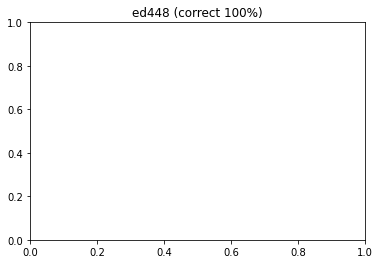

In [19]:
for algo, t in tree.items():
    d = data[algo]
    X_test = d[d['status'] == 'test'][features]
    Y_test = d[d['status'] == 'test'][label]

    #sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['bad\n(rcode != 0 OR\nad != 1)', 'good\n(rcode = 0 AND\nad = 1)'])
    cm = sklearn.metrics.confusion_matrix(t.predict(X_test), Y_test)
    c = np.sum(np.diagonal(cm))/len(Y_test)
    try:
        title = f"{algo} (correct {c:.0%}, false 'bad': {cm[0,1]}, false 'good': {cm[1,0]})"
        plt.title(title)
    except IndexError:
        plt.title(f"{algo} (correct 100%)")


## Show Decision Tree

In [ ]:
graphs = {}

for algo, t in tree.items():
    dot_data = sk.tree.export_graphviz(
        t, out_file=None, 
        feature_names=features,  
        class_names=['OK', 'Failure'],  
        filled=True, rounded=True,  
        special_characters=True,
        impurity=True,
    )  
    graphs[algo] = graphviz.Source(dot_data)  

In [ ]:
graphs['rsasha1']

In [ ]:
graphs['rsasha1nsec3sha1']

In [ ]:
graphs['rsasha256']

In [ ]:
graphs['rsasha512']

In [ ]:
graphs['ecdsap256sha256']

In [ ]:
graphs['ecdsap384sha384']

In [ ]:
graphs['ed25519']

In [ ]:
graphs['ed448']

# Predicting Cipher

In [20]:
# putting all data together
fdata = pd.concat([d for d in data.values()])
fdata = fdata[fdata['status'] == 'test']

In [21]:
# predicting for each algorithm
X = fdata[features]
Y = fdata[label]

for algo, t in tree.items():
    fdata[f'pred_{algo}'] = t.predict(X)

In [22]:
# computing choice for each row
fdata['selected'] = priority[-1]
for algo in priority:
    fdata.loc[fdata[f'pred_{algo}'], 'selected'] = algo

In [23]:
fdata[['resolver', 'qname', 'selected'] + [f'pred_{algo}' for algo in priority]]

,resolver,qname,selected,pred_rsasha1,pred_rsasha1nsec3sha1,pred_rsasha256,pred_rsasha512,pred_ecdsap256sha256,pred_ecdsap384sha384,pred_ed25519,pred_ed448
19,ws2012,b'labdebugiws2012i20210920150444.rsasha1-4096-...,ecdsap384sha384,True,True,True,True,True,True,False,False
154,ws2019,b'labdebugiws2019i20210920150444.rsasha1-2048-...,ecdsap384sha384,True,True,True,True,True,True,False,False
197,b,b'labdebugibind9113i20210920150444.rsasha1-187...,ecdsap384sha384,True,True,True,True,True,True,False,False
199,b,b'labdebugibind9113i20210920150444.rsasha1-204...,ecdsap384sha384,True,True,True,True,True,True,False,False
201,b,b'labdebugibind9113i20210920150444.rsasha1-409...,ecdsap384sha384,True,True,True,True,True,True,False,False
242,kresd532,b'labdebugikresd532i20210920150444.rsasha1-187...,ecdsap384sha384,True,True,True,True,True,True,False,False
244,kresd532,b'labdebugikresd532i20210920150444.rsasha1-204...,ecdsap384sha384,True,True,True,True,True,True,False,False
246,kresd532,b'labdebugikresd532i20210920150444.rsasha1-409...,ecdsap384sha384,True,True,True,True,True,True,False,False
291,powerdns460,b'labdebugipowerdns460i20210920150444.rsasha1-...,ed448,True,True,True,True,True,True,True,True
330,unbound167,b'labdebugiunbound167i20210920150444.rsasha1-1...,ecdsap384sha384,True,True,True,True,True,True,False,False


In [27]:
resolver_best = pd.read_pickle('resolver_best.pickle')[('zone_algorithm', '', 'best_algo')].to_dict()
resolver_best

{'b': 'ecdsap384sha384',
 'kresd532': 'ecdsap384sha384',
 'powerdns460': 'ed448',
 'unbound167': 'ed25519',
 'ws2012': 'ecdsap384sha384',
 'ws2012r2': 'ecdsap384sha384',
 'ws2016': 'ecdsap384sha384',
 'ws2019': 'ecdsap384sha384'}

In [28]:
fdata['best_algo'] = fdata.apply(lambda row: resolver_best.get(row['resolver'], priority[-1]), axis=1)

In [29]:
resolvers = set(resolver_best.keys()) | set(fdata['resolver'].unique())
resolvers_lab = {'bind9113',
 'powerdns460',
 'kresd532',
 'unbound167',
 'ws2012',
 'ws2012r2',
 'ws2016',
 'ws2019'}
resolvers_anon = {r for r in resolvers if r[0] in '0123456789'}
resolvers_named = resolvers - resolvers_anon - resolvers_lab
resolver_order = list(sorted(resolvers_lab)) + list(sorted(resolvers_named) + list(sorted(resolvers_anon)))

In [31]:
# selecting resolvers
resolvers_selected = resolvers_lab 

In [32]:
fdata = fdata[fdata['resolver'].isin(resolvers_selected)]

In [33]:
fdata['best supported'] = fdata.apply(lambda row: resolver_best.get(row['resolver'], None), axis=1)
fdata['pred_num'] = fdata.apply(lambda row: ALGO_NUM[row['selected']], axis=1)
fdata['best_algo_num'] = fdata.apply(lambda row: ALGO_NUM.get(row['best_algo'], None), axis=1)
fdata['correct'] = (fdata['selected'] == fdata['best_algo']).astype(np.float)
fdata['overest.'] = (fdata['pred_num'] > fdata['best_algo_num']).astype(np.float)
fdata['underest.'] = (fdata['pred_num'] < fdata['best_algo_num']).astype(np.float)
fdata['better than recomm.'] = (fdata['pred_num'] > 13).astype(np.float)

In [34]:
fdata = fdata[~fdata['best supported'].isna()]

In [35]:
fdata[['resolver', 'qname', 'selected', 'best supported', 'correct', 'overest.', 'underest.']]

,resolver,qname,selected,best supported,correct,overest.,underest.
19,ws2012,b'labdebugiws2012i20210920150444.rsasha1-4096-...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
154,ws2019,b'labdebugiws2019i20210920150444.rsasha1-2048-...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
242,kresd532,b'labdebugikresd532i20210920150444.rsasha1-187...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
244,kresd532,b'labdebugikresd532i20210920150444.rsasha1-204...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
246,kresd532,b'labdebugikresd532i20210920150444.rsasha1-409...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
291,powerdns460,b'labdebugipowerdns460i20210920150444.rsasha1-...,ed448,ed448,1.0,0.0,0.0
330,unbound167,b'labdebugiunbound167i20210920150444.rsasha1-1...,ecdsap384sha384,ed25519,0.0,0.0,1.0
68,ws2012r2,b'labdebugiws2012r2i20210920150444.rsasha1nsec...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
160,ws2019,b'labdebugiws2019i20210920150444.rsasha1nsec3s...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0
252,kresd532,b'labdebugikresd532i20210920150444.rsasha1nsec...,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0


In [36]:
def list_values(c):
    c = set(c)
    if len(c) == 1:
        return next(iter(c))
    return '(varying)'

def single_value(c):
    c = set(c)
    if len(c) == 0:
        return None
    if len(c) == 1:
        return next(iter(c))
    raise ValueError(set(c))

cipher_selection = fdata[~fdata['best_algo'].isna()].groupby(['resolver']).agg({
    'selected': [list_values],
    'best supported': [single_value],
    'correct': ['mean'],
    'underest.': ['mean'],
    'overest.': ['mean'],
    'better than recomm.': ['mean'],
}).sort_values('resolver', key=lambda r: list(map(lambda e: resolver_order.index(e), r)))
cipher_selection.columns = cipher_selection.columns.droplevel(1)
cipher_selection = cipher_selection.reset_index()
print(cipher_selection.to_latex(
    float_format=lambda f: f"{f:.0%}",
    index=False,
))
cipher_selection.to_csv('cipher_selection.csv')
cipher_selection

\begin{tabular}{lllrrrr}
\toprule
   resolver &        selected &  best supported &  correct &  underest. &  overest. &  better than recomm. \\
\midrule
   kresd532 & ecdsap384sha384 & ecdsap384sha384 &     100\% &         0\% &        0\% &                 100\% \\
powerdns460 &           ed448 &           ed448 &     100\% &         0\% &        0\% &                 100\% \\
 unbound167 & ecdsap384sha384 &         ed25519 &       0\% &       100\% &        0\% &                 100\% \\
     ws2012 & ecdsap384sha384 & ecdsap384sha384 &     100\% &         0\% &        0\% &                 100\% \\
   ws2012r2 & ecdsap384sha384 & ecdsap384sha384 &     100\% &         0\% &        0\% &                 100\% \\
     ws2016 & ecdsap384sha384 & ecdsap384sha384 &     100\% &         0\% &        0\% &                 100\% \\
     ws2019 & ecdsap384sha384 & ecdsap384sha384 &     100\% &         0\% &        0\% &                 100\% \\
\bottomrule
\end{tabular}



,resolver,selected,best supported,correct,underest.,overest.,better than recomm.
0,kresd532,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
1,powerdns460,ed448,ed448,1.0,0.0,0.0,1.0
2,unbound167,ecdsap384sha384,ed25519,0.0,1.0,0.0,1.0
3,ws2012,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
4,ws2012r2,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
5,ws2016,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
6,ws2019,ecdsap384sha384,ecdsap384sha384,1.0,0.0,0.0,1.0
